In [ ]:
import os
import logging
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec


db_params = {
    'host': '',
    'database': '',
    'user': '',
    'password': '',
    'port': 
}

def alpha_postgres_connection():
    try:
        conn = psycopg2.connect(**db_params)
        logging.info("Connection established successfully!")
        conn.autocommit = True
        return conn, conn.cursor()
    
    except Exception as e:
        logging.info(f"Error connecting to PostgreSQL database: {e}")

conn, cursor = alpha_postgres_connection()

In [49]:
cursor.execute(f"""
            SELECT * 
            FROM tb_daily_stocks 
            WHERE nm_symbol = 'IBM'
            and dt_reference >= '2024-10-24'
            ORDER BY dt_reference;
    """)

data = cursor.fetchall()

In [50]:
df_ibm = pd.DataFrame(data, columns=["nm_symbol", "dt_reference", "vl_open", "vl_high", "vl_low", "vl_close", "qt_volume"])

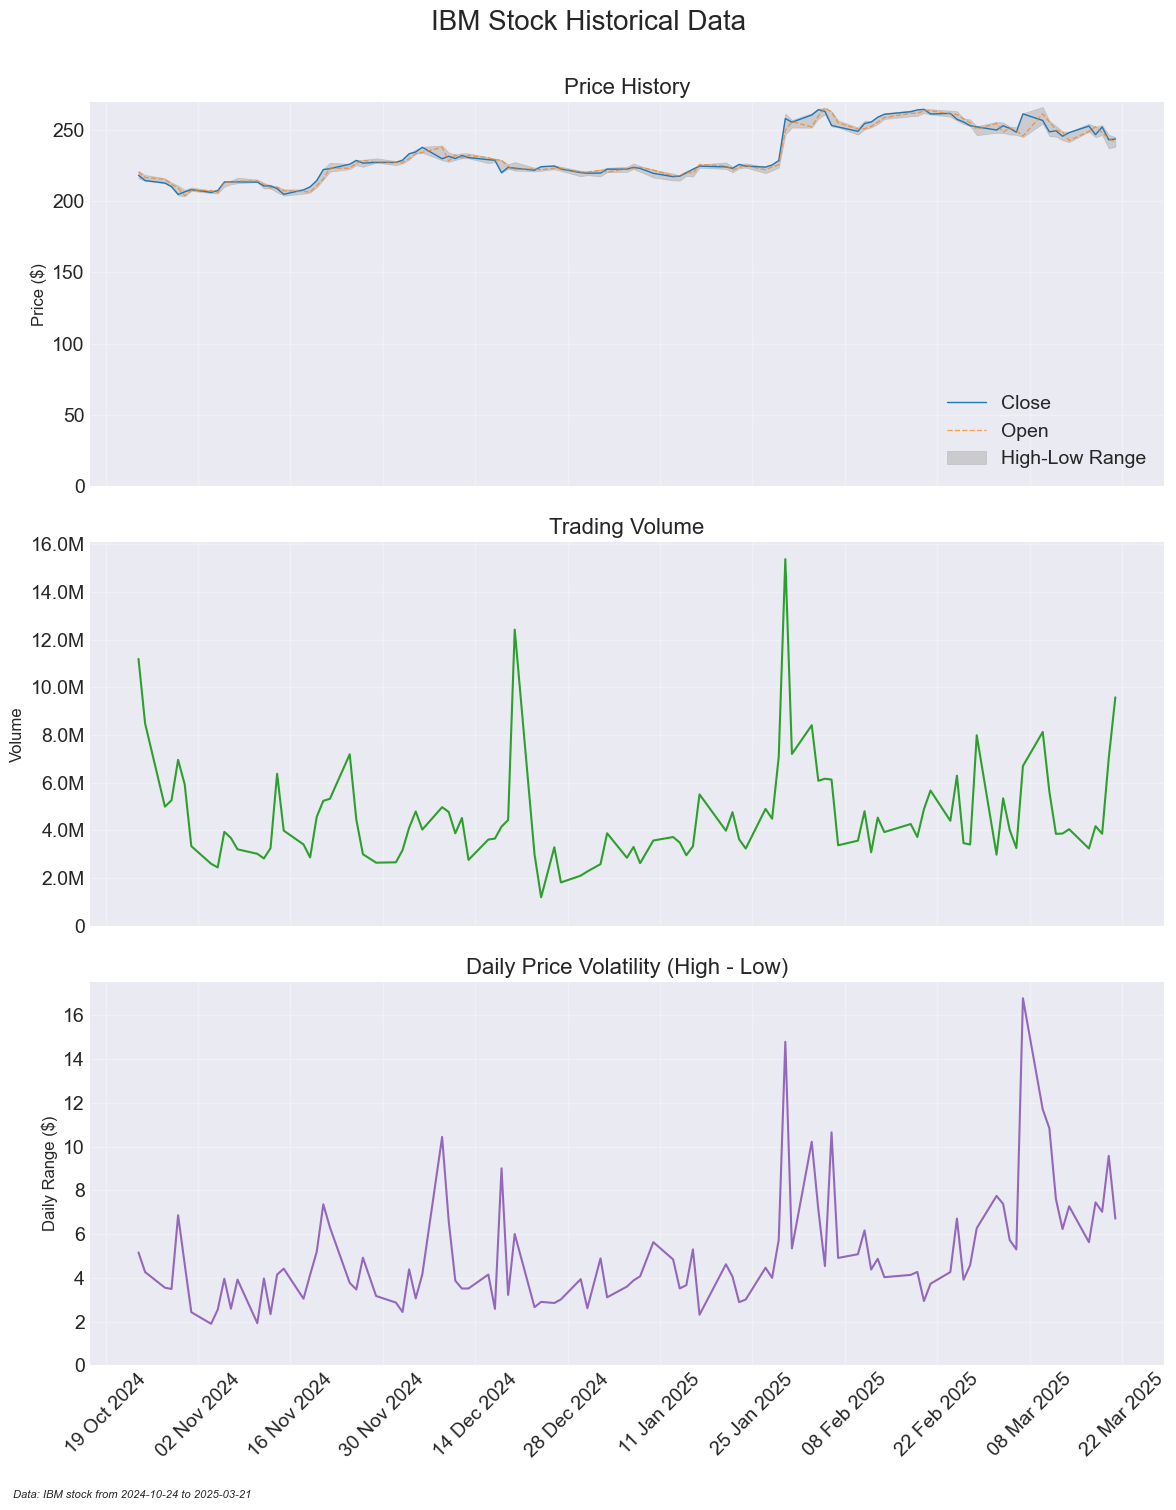

In [64]:
df_ibm['dt_reference'] = pd.to_datetime(df_ibm['dt_reference'])

df_plot = df_ibm.set_index('dt_reference')

def format_with_suffix(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    elif x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K'
    else:
        return f'{int(x)}'

plt.style.use('seaborn-v0_8-darkgrid')

fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
fig.suptitle('IBM Stock Historical Data', fontsize=20, y=0.95)

axs[0].plot(df_plot.index, df_plot['vl_close'], label='Close', linewidth=1, color='#1f77b4')
axs[0].plot(df_plot.index, df_plot['vl_open'], label='Open', linestyle='--', linewidth=1, alpha=0.7, color='#ff7f0e')
axs[0].fill_between(df_plot.index, df_plot['vl_high'], df_plot['vl_low'], alpha=0.3, color='gray', label='High-Low Range')
axs[0].set_ylabel('Price ($)', fontsize=12)
axs[0].set_title('Price History', fontsize=16)
axs[0].legend(loc='lower right')
axs[0].grid(True, alpha=0.3)
axs[0].set_ylim(bottom=0)

axs[1].plot(df_plot.index, df_plot['qt_volume'], color='#2ca02c', linewidth=1.5)
axs[1].set_ylabel('Volume', fontsize=12)
axs[1].set_title('Trading Volume', fontsize=16)
axs[1].yaxis.set_major_formatter(FuncFormatter(format_with_suffix))
axs[1].grid(True, alpha=0.3)
axs[1].set_ylim(bottom=0)

df_plot['daily_range'] = df_plot['vl_high'] - df_plot['vl_low']
axs[2].plot(df_plot.index, df_plot['daily_range'], color='#9467bd', linewidth=1.5)
axs[2].set_ylabel('Daily Range ($)', fontsize=12)
axs[2].set_title('Daily Price Volatility (High - Low)', fontsize=16)
axs[2].grid(True, alpha=0.3)
axs[2].set_ylim(bottom=0)

for ax in axs:
    # For shorter time periods, use WeekdayLocator
    if (df_plot.index.max() - df_plot.index.min()).days < 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.figtext(0.02, 0.02, f"Data: IBM stock from {df_plot.index.min().strftime('%Y-%m-%d')} to {df_plot.index.max().strftime('%Y-%m-%d')}", 
           fontsize=8, style='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()